<div align="center">

# Deep Learning Project - Language Model
by Carmen ZAROLA

</div>


### **Objective**
Implement a transformer-based, character-level language model (GPT-like) and train it on the Shakespeare dataset. By the end of this project, you should be able to generate Shakespearean-like text given a seed string.

**Importing Pytorch**

In [1]:
import torch
print(torch.version.cuda)

12.1


## Downloading the data

In [2]:
import requests

url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
text = requests.get(url).text

print("Length of dataset:", len(text))
text[:500]


Length of dataset: 1115394


"First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you know Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us kill him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be done: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor"

 ## Tokenisation

For this project, we wish to implement/train a **character-level language model**. Before training the model, we need to convert the text into **numerical tokens**. Here, one token = one character. 

As explained in the instructions, in a character-level language model, each character in the input data is mapped to its respective index from a dictionary.This is what is implemented in the code below.


General remarks:
- Tokenisation is necessary as the transformer architecture natively consists of operations over numbers (matrix multiplications, dot products, activation functions) rather than over text. Therefore, there must first be a mapping from any input text to some numerical representation.
- A language model learns how to predict the next unit of text (word or character). Here, we choose a character-level model because the vocabulary is smaller. It is also simpler and learns raw linguistic structure. However, it is harder for the model to learn semantics.

In [3]:
#Retrieves all the set of characters in text, converts them into a list, and sorts the list.
chars = sorted(list(set(text)))
vocab_size = len(chars)


#Creates two maps (to go from text to integers and vice versa).
stoi = {ch: i for i, ch in enumerate(chars)} #string -> int
itos = {i: ch for i, ch in enumerate(chars)} #int -> string

# For encoding and decoding
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[i] for i in l])

data = torch.tensor(encode(text), dtype=torch.long)


## Creating the batches

We split the dataset in (random) batches.

**Remarks:**

- block_size is the length of the "context" seen by the model. Each batch will contain only this number of characters. block_size should be chosen carefully as:
    1. A too short context means loss of information.
    2. A too long context makes the model heavy and slower.

- batch_size is the number of sequences (samples) processed in parallel during training. As seen during the lessons, dividing the data into batches is necessary for different reasons, in particular  performance. Indeed, to evaluate a module on a sample, both the module's parameters and the sample must be copied into cache memory, which is fast but small. Memory transfers are slower than computation. Batch processing allows us to cut down to one copy of the parameters to the cache per batch. 

- Randomly choosing the sequences avoids that the model sees always the same sequences. It improves generalization, increases the diversity of the examples, avoids learning consecutive sequences.

- It is also important to choose the batch size carefully. Indeed, the batch size determines how many samples are used to compute the gradient before updating the parameters. A too small batch will produce a noisy gradient, whereas a bigger batch will produce a more stable gradient. Also, bigger batches can exploit the performance of GPUs. However, too big batches will worsen the performance of the model and therefore other tricks are used to counter that  (eg. gradient clipping).

In [4]:
import torch
import torch.nn as nn

#We chose the suggested parameters.
block_size = 128
batch_size = 128

def get_batch(split):
    #Split data into training set and testing/validation set
    data_split = data[:int(0.9*len(data))] if split=="train" else data[int(0.9*len(data)):]
    
    #Randomly selects the initial indices for each batch.
    ix = torch.randint(len(data_split) - block_size, (batch_size,))
    # We store the inputs to the model
    x = torch.stack([data_split[i:i+block_size] for i in ix])
    #Stores the input batches shifted by one index. This corresponds to the desired prediction/targets/labels (corresponds to next-character prediction learning).
    y = torch.stack([data_split[i+1:i+block_size+1] for i in ix])
    return x, y


# Implémentation du Transformer

#### **Architecture requirements**

Implement the Transformer's decoder-only structure.
This includes

* input token embeddings
* the causal multi-head self-attention mechanism
* feed-forward neural networks
* positional encodings, residual connections, layer normalizations.

The project was tested with $12$ layers, $8$ attention heads, and $768$ embedding dimensions, on a single GPU.

The `forward` method for the entire model has the following form:

```
tok_emb = WTE(idx) # token embeddings
pos_emb = WPE(pos) # position embeddings
x = Dropout(tok_emb + pos_emb)
for Block in Blocks:
    x = Block(x)
x = Final_LayerNorm(x)
logits = LM_Head(x)
```

The `forward` method for the transformer block has the following form:



```
x = x + self.CausalSelfAttn(self.LayerNorm_1(x))
out = x + self.MLP(self.LayerNorm_2(x))
```

---

### Attention head and multi-head self-attention mechanism

**Theoretical remarks:**

- The general idea behind the multi-head self-attention mechanism is that our model needs, for each position t in the sentence, to choose which previous positions are important to predict the next token. The self-attention allows the model to "look" at the previous positions and "weight" its attention on them.

- The attention mechanism used in the transformer architecture are scaled dot-product attention units. For each unit, the transformer model learns three weight matrices: the query weights $W_Q$, the key weights $W_K$ and the value weights $W_V$.

- It computes the matrices $Q=W_QX$,$K=W_KX$, $V=W_VX$ (linear transformation -> using nn.Linear in our code below with bias=False).

- It computes the **attention weights** as $QK^T$ and divides them by the square root of the dimension of key vectors (to stabilize the gradients during the training).

- This (self-) attention mechanism can be expressed by the following expression:

<div align="center">

$Attention(Q,K,V)=softmax(\frac{QK^T}{\sqrt{d_k}})V$

</div>


- One set of $(W_Q,W_K,W_V)$ matrices is called **attention head**. Intuitively, with one head, we/a token can only learn one type of relation. Using multiple heads, the multi-head attention allows the model to look at the text from "different angles" at the same time. The model learns different relationships between the tokens. Each head will learn "its own way of giving attention".

- Causal masking ensures that each position has access to its own position and all preceding positions, but is prevented from attending to future ones.

The structure of an head attention and of the multi-head self-attention mechanism are summarized in the schemes below taken from : https://en.wikipedia.org/wiki/Transformer_(deep_learning) 

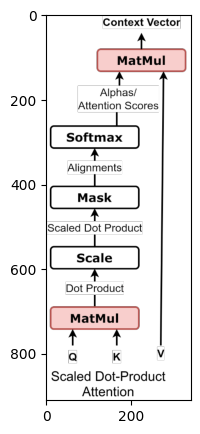

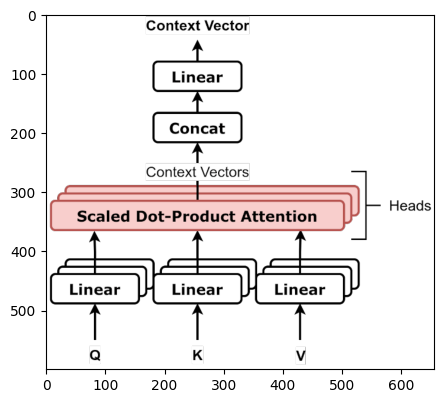

In [5]:
from PIL import Image
import matplotlib.pyplot as plt

imageHead=Image.open("./Head.png")

plt.figure(figsize=(5,5))
plt.imshow(imageHead)
plt.show()


imageMultiHead=Image.open("./MultiHead.png")
plt.figure(figsize=(5,5))
plt.imshow(imageMultiHead)
plt.show()

In [6]:
class Head(nn.Module):
    def __init__(self, head_size, n_embd):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)

        self.register_buffer("tril", torch.tril(torch.ones(block_size, block_size)))

    def forward(self, x):
        B, T, C = x.shape
        #NB: B is the batch size, T is the length of the sequence (block_size), C is the embedding dimension n_embd
        k = self.key(x) #Compute K
        q = self.query(x) #Compute Q

        weights = q @ k.transpose(-2, -1) * C**-0.5 #Compute the attention weights and scale them.
        weights = weights.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        weights = torch.softmax(weights, dim=-1)

        v = self.value(x)
        out = weights @ v
        return out


In [7]:
class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, head_size, n_embd):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size, n_embd) for _ in range(num_heads)])
        self.proj = nn.Linear(num_heads * head_size, n_embd)

    def forward(self, x): 
        out = torch.cat([h(x) for h in self.heads], dim=-1) #Concatenate 
        return self.proj(out) #Apply final projection


## Feed-forward neural network

**Theoretical remarks:**

In a transformer, the feedforward network (FFN) modules are 2-layered multilayer perceptrons:

<div align="center">

$FFN(x)=W_2\phi(W_1x+b_1)+b_2$

</div>

where $W_1,W_2$ are weight matrices and $b_1,b_2$ bias vectors, and $\phi$ is the activation function. Here, we chose the ReLU activation function (as in the original transformer).

The number of neurons in the middle layer is called **intermediate/filter/feedforward size** and is usually larger than the embedding size. Here, it is chosen as $4*n_{embd}$ where $n_{embd}$ is the embedding dimension.

The FFN adds non-linearity. Son rôle  plus?


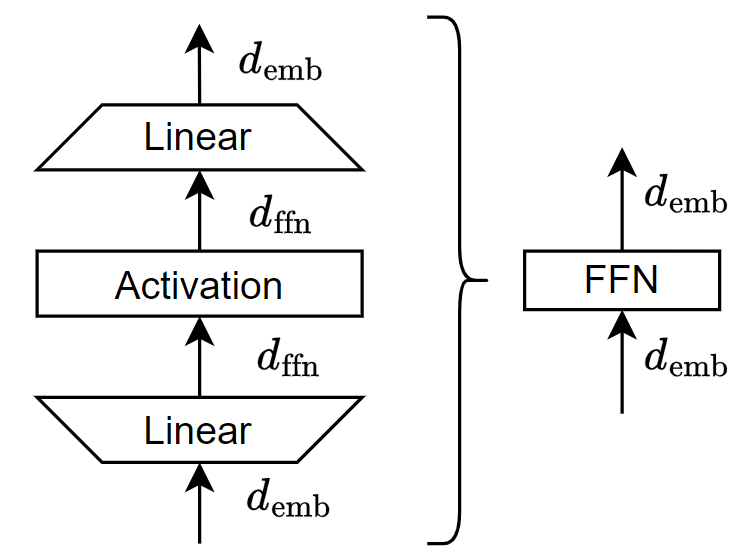

In [8]:
from PIL import Image

image = Image.open('./FFN.png')

image   

#Image from: https://en.wikipedia.org/wiki/Transformer_(deep_learning)

In [9]:
class FeedForward(nn.Module):
    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd), 
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
        )

    def forward(self, x):
        return self.net(x)


## Transformer block

**Reminder:**

The `forward` method for the transformer block has the following form:



```
x = x + self.CausalSelfAttn(self.LayerNorm_1(x))
out = x + self.MLP(self.LayerNorm_2(x))
```

---


**Remarks**:
- The Transformer block is the core reusable building unit of a Transformer model.

- The general ideal nehind the transformer block is that it enriches each token with contextual information from the entire past (via attention), then transforms that information non-linearly (via a feed-forward network), while keeping training stable. So, each block makes token representations more context-aware and more expressive.

- Layer normalization is important because it stabilizes activations, keeps values in a reasonable range and improves gradient flow. Applying layer normalization **avoids exploiding/vanishing gradients**.

- Residual connection is important as it prevents degradation in deep networks. Without residuals, deep Transformers fail to train. Residuals preserve original information.

- Intuitively: Attention mixes information across tokens, FFN transforms information within each token.

- In summary, a Transformer block refines token representations by mixing contextual information (attention) and transforming it non-linearly (FFN), while residual connections and normalization ensure stable training.

In [10]:
class Block(nn.Module):
    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size, n_embd)
        self.ffwd = FeedForward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        """This method follows the demanded structure."""
        x = x + self.sa(self.ln1(x)) #Layer norm, self-attention and residual connection
        x = x + self.ffwd(self.ln2(x))
        return x


## Complete model

**Reminder:**
The `forward` method for the entire model has the following form:

```
tok_emb = WTE(idx) # token embeddings
pos_emb = WPE(pos) # position embeddings
x = Dropout(tok_emb + pos_emb)
for Block in Blocks:
    x = Block(x)
x = Final_LayerNorm(x)
logits = LM_Head(x)
```

**Remarks:**
Dropout is a *regularization technique* that randomly sets a fraction of activations to zero during training. This is done only during training, not during inference.


- Dropout is necessary to avoid the model overfits. It forces redundancy, robustness and better generalization. Here, we apply embedding dropout. It prevents the model from relying too strongly on exact embeddings, regularizes the entire model early and improves stability downstream.

In [11]:
#Hyperparameters
# Used the suggested parameters
n_embd = 256
n_head = 8
n_layer = 12

dropout=0.1

class TransformerLanguageModel(nn.Module):
    def __init__(self):
        super().__init__() #Initialize inherited structure
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.dropout = nn.Dropout(dropout)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        """The forward method follows the demanded structure """
        B, T = idx.shape

        tok_emb = self.token_embedding_table(idx) #Token embeddings
        pos_emb = self.position_embedding_table(torch.arange(T, device=idx.device)) #Position embedding  
        #Dropout
        x = self.dropout(tok_emb + pos_emb)

        x = self.blocks(x) #Apply block
        x = self.ln_f(x) #Final layer norm
        logits = self.lm_head(x) 

        if targets is None: #Important for generation
            return logits
        
        #Compute the loss function (cross-entropy)
        loss = nn.functional.cross_entropy(
            logits.view(-1, vocab_size), 
            targets.view(-1)
        )

        return logits, loss


# Entraînement


Remarks

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model1 = TransformerLanguageModel().to(device)
model1.train() #Not really necessary here 
print(next(model1.parameters()).device)

optimizer = torch.optim.AdamW(model1.parameters(), lr=3e-4) #Use AdamW optimizer

max_steps = 6000 #As in the given example in the instructions.
losses=[]

for step in range(max_steps):
    xb, yb = get_batch("train") #Create a batch
    xb, yb = xb.to(device), yb.to(device)
    logits, loss = model1(xb, yb) 
    losses.append(loss)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()  #Updates the parameters using optimizer method.

    if step % 500 == 0: # Print the loss
        print(f"Step {step}/{max_steps} - loss: {loss.item():.4f}")

cuda:0
Step 0/6000 - loss: 4.3450
Step 500/6000 - loss: 1.8888
Step 1000/6000 - loss: 1.4979
Step 1500/6000 - loss: 1.3908
Step 2000/6000 - loss: 1.2666
Step 2500/6000 - loss: 1.1804
Step 3000/6000 - loss: 1.0927
Step 3500/6000 - loss: 0.9722
Step 4000/6000 - loss: 0.8502
Step 4500/6000 - loss: 0.7393
Step 5000/6000 - loss: 0.6164
Step 5500/6000 - loss: 0.5236


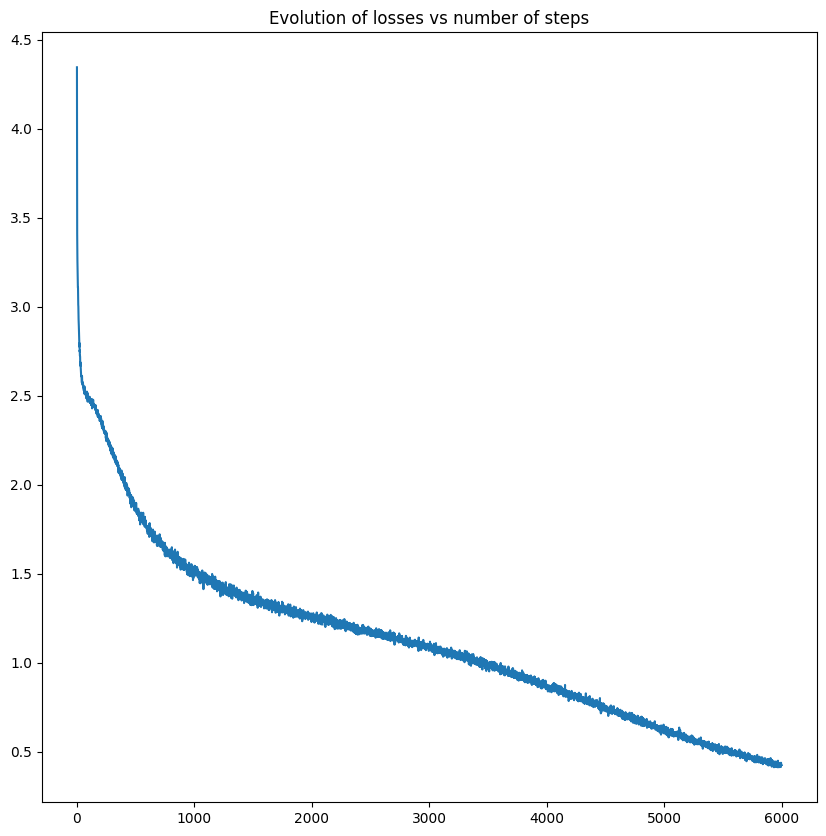

In [ ]:
#Plotting the evolution of the losses
import numpy as np
import matplotlib.pyplot as plt

losses_cpu = [loss.detach().cpu().item() for loss in losses]

N=np.arange(0,6000)

plt.figure(figsize=(10,10))
plt.plot(N,losses_cpu)
plt.title("Evolution of losses vs number of steps")
plt.show()


**Training with learning rate decay and gradient clipping**

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2 = TransformerLanguageModel().to(device)
model2.train() #Not really necessary here 
print(next(model2.parameters()).device)

optimizer = torch.optim.AdamW(model2.parameters(), lr=3e-4)

# Learning-rate decay (cosine)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=6000)

# Gradient clipping threshold
grad_clip = 1.0

max_steps = 6000
losses = []

for step in range(max_steps):
    xb, yb = get_batch("train")
    xb, yb = xb.to(device), yb.to(device)
    logits, loss = model2(xb, yb)
    losses.append(loss.item())

    optimizer.zero_grad()
    loss.backward()

    # Gradient clipping
    torch.nn.utils.clip_grad_norm_(model2.parameters(),grad_clip)

    optimizer.step()

    #Learning-rate decay
    scheduler.step()

    if step % 500 == 0:
        lr = scheduler.get_last_lr()[0]
        print(f"Step {step}/{max_steps} - loss: {loss.item():.4f} - lr: {lr:.6f}")


cuda:0
Step 0/6000 - loss: 4.3488 - lr: 0.000300
Step 500/6000 - loss: 1.8368 - lr: 0.000295
Step 1000/6000 - loss: 1.4937 - lr: 0.000280
Step 1500/6000 - loss: 1.3539 - lr: 0.000256
Step 2000/6000 - loss: 1.2509 - lr: 0.000225
Step 2500/6000 - loss: 1.1820 - lr: 0.000189
Step 3000/6000 - loss: 1.0939 - lr: 0.000150
Step 3500/6000 - loss: 1.0169 - lr: 0.000111
Step 4000/6000 - loss: 0.9554 - lr: 0.000075
Step 4500/6000 - loss: 0.8953 - lr: 0.000044
Step 5000/6000 - loss: 0.8591 - lr: 0.000020
Step 5500/6000 - loss: 0.8494 - lr: 0.000005


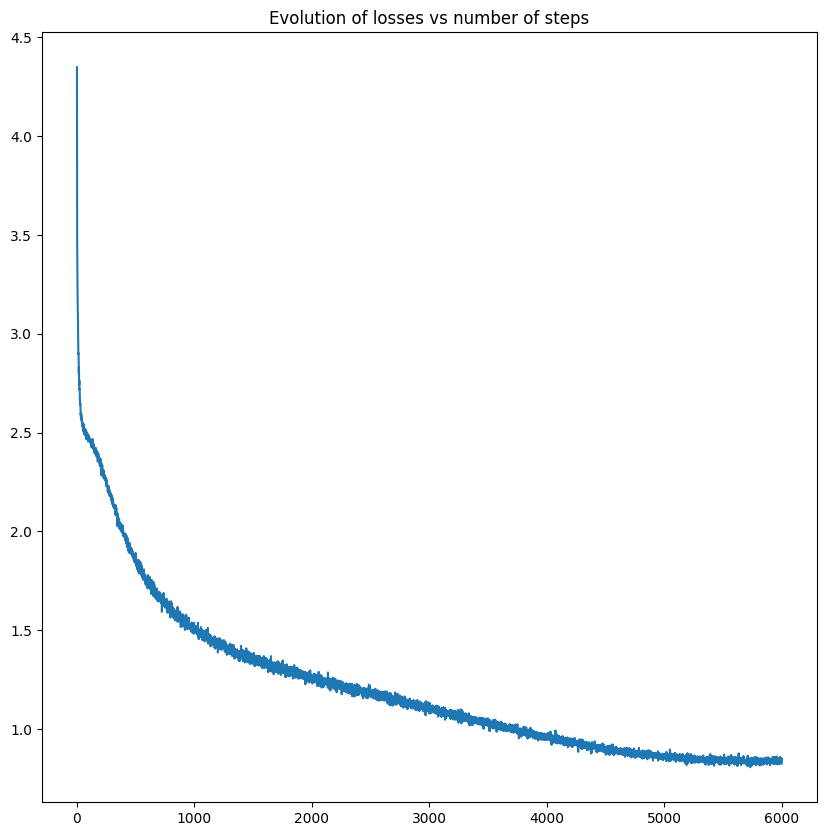

In [20]:
#Plotting the evolution of the losses
import numpy as np
import matplotlib.pyplot as plt

N=np.arange(0,6000)

plt.figure(figsize=(10,10))
plt.plot(N,losses)
plt.title("Evolution of losses vs number of steps")
plt.show()


**Remarks:**
- Explain gradient clipping and learning rate decay and their importance.

# Génération de texte

In [23]:
def generate(model, start="O God, O God!", max_new_tokens=300):
    """Inputs:
    - model
    - start
    - max_new_tokens"""

    model.eval() #Necessary to disable dropout and training-only behaviors

    device = next(model.parameters()).device  # Get model device

    idx = torch.tensor(encode(start),dtype=torch.long,device=device)[None, :] #Need to put it in the GPU too


    for _ in range(max_new_tokens):
        logits = model(idx[:, -block_size:]) #Attention, we need to truncate the context (block_size) and keep the most recent tokens.
        logits = logits[:, -1, :]
        probs = torch.softmax(logits, dim=-1) #Transforms into probability distribution
        next_id = torch.multinomial(probs, 1) #Sample the next token with respect to this probability distribution
        idx = torch.cat((idx, next_id), dim=1) #Concatenate the chosen token

    return decode(idx[0].tolist()) #Decode the tokens 

print("Generation with first model:\n",generate(model1, max_new_tokens=600))
print("\nGeneration with second model:\n",generate(model2, max_new_tokens=600))


Generation with first model:
 O God, O God! that e'er this tongue of this spark,
Envine own the sty tongue--

Of one so near, would not our meeds s.

LORD ROSS:
To instruct the council permise here.
I will not say that take Vince of this:
It is a surpland, or taken veil, or draw off,
I cannot put in step and since I do think.
Some couple in mine own descent of myself?
If I be intend possible to die,
If grace come to pluck in absence,
And with an iron with t'other, nor 'twere not
Unless the waning to our true. Zine comes friend!
I am the soft that first which I would mad;
And never will it with the cuckolds.

LEONTES:
Thou dost trake
He

Generation with second model:
 O God, O God! merve a brank,
And little filly the day, who look your son,
As much past chafety your helmets that had saints
Shall be now undertake twelve the captages,
They draw thee better and holy derrorard,
By his aspiral, poor quite of the king.

Servant:
How now! when, Has I the supposed you could
set the better broug